In [4]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import marsilea as ma
import marsilea.plotter as mp
import scienceplots
# %matplotlib widget
import pickle
plt.style.use(['science', 'nature'])
import numpy as np
from itertools import combinations, product
from pyarrow import feather

In [24]:
tool_map = {
    "scapa": "scAPA",
    "scapatrap": "scAPAtrap",
    "sierra": "Sierra",
    "maaper": "MAAPER",
    "scapture": "SCAPTURE",
    "scape": "SCAPE",
    "infernape": "Infernape",
}

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
}

protocol_order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
tool_order = ["SCAPE", "scAPAtrap", "Infernape", "SCAPTURE", "scAPA",  "Sierra"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]

palette=sns.color_palette(color, 7)
mm = 1/25.4

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["legend.title_fontsize"] = 6
plt.rcParams['hatch.linewidth'] = 0.5

In [10]:

te_gap_df = feather.read_feather('/root/apabenchmark/data/performance/te_gap.feather')

In [13]:

gap_ranges = [(i, i+100) for i in range(200, 1000, 100)] + [(1000, float('inf'))]
count_ranges = [(i, i+50) for i in range(50, 500, 50)] + [(500, float('inf'))]
te_gap_df["match"] = te_gap_df["pd_pas_num"] > 1
te_gap_df['gap_range'] = pd.cut(te_gap_df['max_gap'], bins=[r[0] for r in gap_ranges] + [float('inf')], labels=[f"{r[0]}-{r[1]}" for r in gap_ranges], right=False)
te_gap_df['count_range'] = pd.cut(te_gap_df['max_gap_min_counts'], bins=[r[0] for r in count_ranges] + [float('inf')], labels=[f"{r[0]}-{r[1]}" for r in count_ranges], right=False)

gap_match_ratio = (te_gap_df.groupby(["tool", "gap_range"])["match"].sum() / te_gap_df.groupby(["tool", "gap_range"])["match"].count()).reset_index()
gap_match_ratio["tool"] = gap_match_ratio["tool"].map(tool_map)
gap_match_ratio["tool"] = pd.Categorical(gap_match_ratio["tool"], tool_order)
min_count_match_ratio = (te_gap_df.groupby(["tool", "count_range"])["match"].sum() / te_gap_df.groupby(["tool", "count_range"])["match"].count()).reset_index()
min_count_match_ratio["tool"] = min_count_match_ratio["tool"].map(tool_map)
min_count_match_ratio["tool"] = pd.Categorical(min_count_match_ratio["tool"], tool_order)

In [41]:
slop_list = te_gap_df.columns[te_gap_df.columns.str.contains("slop")].tolist()
slop_list = slop_list + ["pd_pas_num"]

In [42]:
slop_match_ratio = pd.DataFrame()
for slop in slop_list:
    if slop == "pd_pas_num":
        extend=0
    else:
        extend = int(slop.split("_")[-1])
    te_gap_df[f"match{extend}"] = te_gap_df[slop] > 1
    match_ratio = (te_gap_df.groupby(["tool"])[f"match{extend}"].sum() / te_gap_df.groupby(["tool"])[f"match{extend}"].count()).reset_index()
    match_ratio.columns = ["tool", "match"]
    match_ratio["extend"] = extend
    slop_match_ratio = pd.concat([slop_match_ratio, match_ratio], axis=0)

slop_match_ratio = slop_match_ratio.reset_index(drop=True)
slop_match_ratio["tool"] = slop_match_ratio["tool"].map(tool_map)
slop_match_ratio["tool"] = pd.Categorical(slop_match_ratio["tool"], tool_order)

/tmp/ipykernel_1325657/4211044306.py:5: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_1325657/4211044306.py:8: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_1325657/4211044306.py:11: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_1325657/4211044306.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_1325657/4211044306.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


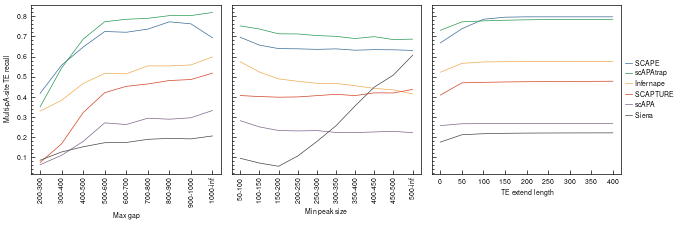

In [48]:
plt.close()
fig, axs = plt.subplots(1,3, figsize=(175*mm, 60*mm), sharey=True)
legend_flag = False

sns.lineplot(
    data=gap_match_ratio, x="gap_range", y="match", hue="tool", ax=axs[0], palette=palette, hue_order=tool_order,linewidth=0.5, legend=legend_flag
)
sns.lineplot(
    data=min_count_match_ratio, x="count_range", y="match", hue="tool", ax=axs[1], palette=palette, hue_order=tool_order,linewidth=0.5, legend=legend_flag
)
sns.lineplot(
    data=slop_match_ratio, x="extend", y="match", hue="tool", ax=axs[2], palette=palette, hue_order=tool_order,linewidth=0.5, legend=True
)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for ax in axs:
    ax.tick_params(which="minor", bottom=False )

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[2].set_xticks(slop_match_ratio["extend"].unique().tolist())
axs[0].set_ylabel("Multi-pA-site TE recall")
axs[0].set_xlabel("Max gap")
axs[1].set_xlabel("Min peak size")
axs[2].set_xlabel("TE extend length")
plt.tight_layout()
# plt.savefig("/root/apabenchmark/plot/suppfig/te_gap_match_ratio.pdf", bbox_inches='tight', dpi=300)